In [ ]:
# Импорт необходимых библиотек
import warnings
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl
import torch
import matplotlib.pyplot as plt
from pytorch_forecasting.metrics import RMSE
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters




In [361]:
from torchmetrics import MetricCollection, MeanAbsoluteError, MeanSquaredError, R2Score


In [345]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [346]:
# Загрузка данных
data = yf.download('NVDA', start='2020-01-01', end='2024-01-01')


[*********************100%***********************]  1 of 1 completed


In [347]:
data['time_idx'] = range(len(data))  # Индекс времени
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['Volatility'] = data['High'] - data['Low']
data['Price_Change'] = data['Close'].diff()
data.bfill(inplace=True)
data.ffill(inplace=True)

In [348]:
data.reset_index(inplace=True)
data.columns = data.columns.droplevel(1)
data.drop(columns=['Date'], inplace=True)
data["series_id"] = 0  # один уникальный идентификатор для всего ряда

In [349]:
scaler = MinMaxScaler()
data["SMA_10"] = scaler.fit_transform(data[["SMA_10"]])
data["SMA_20"] = scaler.fit_transform(data[["SMA_20"]])
data["Volatility"] = scaler.fit_transform(data[["Volatility"]])
data["Volume"] = scaler.fit_transform(data[["Volume"]])

In [350]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,time_idx,SMA_10,SMA_20,EMA_10,Volatility,Price_Change,series_id
0,5.973122,5.99775,5.99775,5.91800,5.96875,0.096576,0,0.012903,0.005047,5.997750,0.004776,-0.09600,0
1,5.877518,5.90175,5.94575,5.85250,5.87750,0.074342,1,0.012903,0.005047,5.980295,0.008001,-0.09600,0
2,5.902164,5.92650,5.93175,5.78175,5.80800,0.113934,2,0.012903,0.005047,5.970514,0.021553,0.02475,0
3,5.973620,5.99825,6.04425,5.90975,5.95500,0.150047,3,0.012903,0.005047,5.975557,0.017852,0.07175,0
4,5.984824,6.00950,6.05100,5.95375,5.99400,0.123942,4,0.012903,0.005047,5.981729,0.008956,0.01125,0


In [351]:
# Подготовка данных для TimeSeriesDataSet
max_encoder_length = 100  # Длина входной последовательности
max_prediction_length = 1  # Длина прогноза (1 шаг вперёд)
training_cutoff = data["time_idx"].max() - max_prediction_length

In [352]:
# Создание TimeSeriesDataSet
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Close",
    group_ids=["series_id"],  # Указываем фиктивный идентификатор группы
    min_encoder_length=max_encoder_length //2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # Нет категориальных данных
    time_varying_known_reals=[],  # Временные признаки, известные заранее
    time_varying_unknown_reals=["Close","High","Open","SMA_10","SMA_20","EMA_10"],  # Используем только значение закрытия
    target_normalizer=GroupNormalizer(groups=["series_id"], transformation="softplus"),  
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


In [353]:
validation = TimeSeriesDataSet.from_dataset(training,data, predict=True,stop_randomization=True)

In [354]:
#Размеры батча
batch_size = 64
train_dataloader = training.to_dataloader(train=True,batch_size=batch_size,num_workers = 0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [355]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

In [356]:
trainer = pl.Trainer(
    accelerator='gpu',
    gradient_clip_val=0.1,
    max_epochs=50,
    #fast_dev_run = True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    log_every_n_steps=5
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=128,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.2,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=32,  # set to <= hidden_size
    loss=RMSE(),
    optimizer="ranger",
    
)
print(f"Число параметров сети: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Число параметров сети: 954.7k


C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [357]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 640    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 34.1 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 81.5 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 11.3 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [358]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
from pytorch_forecasting.metrics import MAE

# Получение предсказаний и реальных значений для оценки
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))

# Расчет средней абсолютной ошибки (MAE)
mae = MAE()(predictions.output, predictions.y)
print(f"Mean Absolute Error (MAE): {mae.item()}")



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Mean Absolute Error (MAE): 2.290424346923828


In [ ]:
# Создание коллекции метрик
metrics = MetricCollection([
    MeanAbsoluteError().to(device),
    MeanSquaredError().to(device),  # RMSE

])

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

# Получаем предсказания
predictions = best_tft.predict(val_dataloader, mode="prediction")
# Проверим формы перед передачей в метрики


predictions = predictions.flatten().to(device)  
actuals = actuals.flatten().to(device)  
print(f"Shape of predictions: {predictions.shape}")
print(f"Shape of actuals: {actuals.shape}")


# Применяем метрики
metrics_result = metrics(predictions, actuals)
print(f"Metrics: {metrics_result}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Shape of predictions: torch.Size([1])
Shape of actuals: torch.Size([1])
Metrics: {'MeanAbsoluteError': tensor(2.2904, device='cuda:0'), 'MeanSquaredError': tensor(5.2460, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


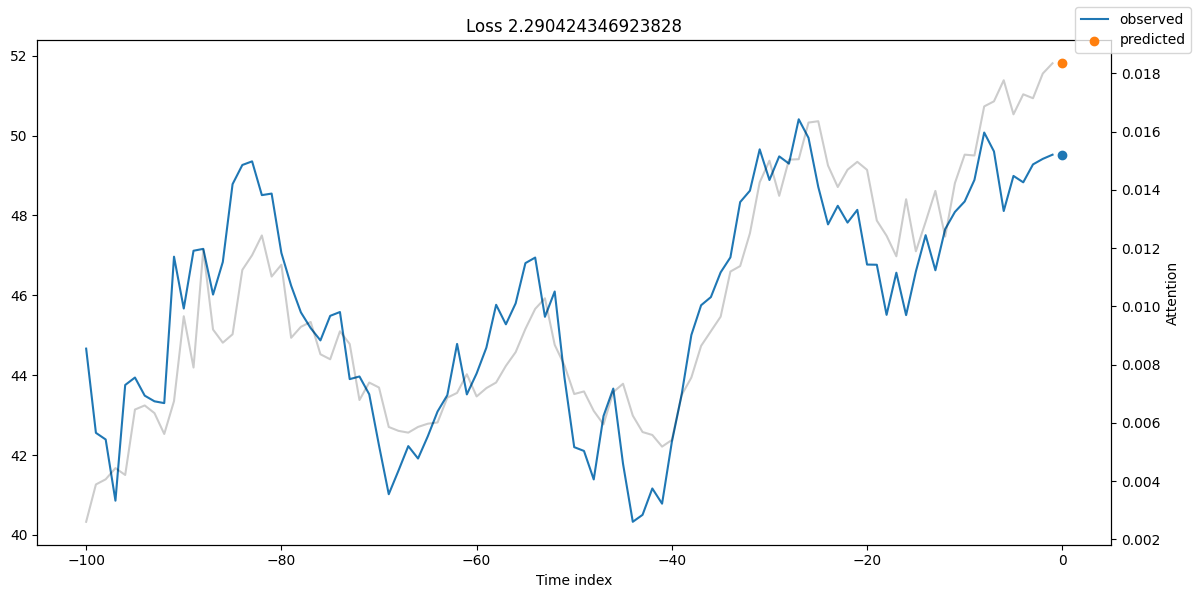

IndexError: index 1 is out of bounds for dimension 0 with size 1

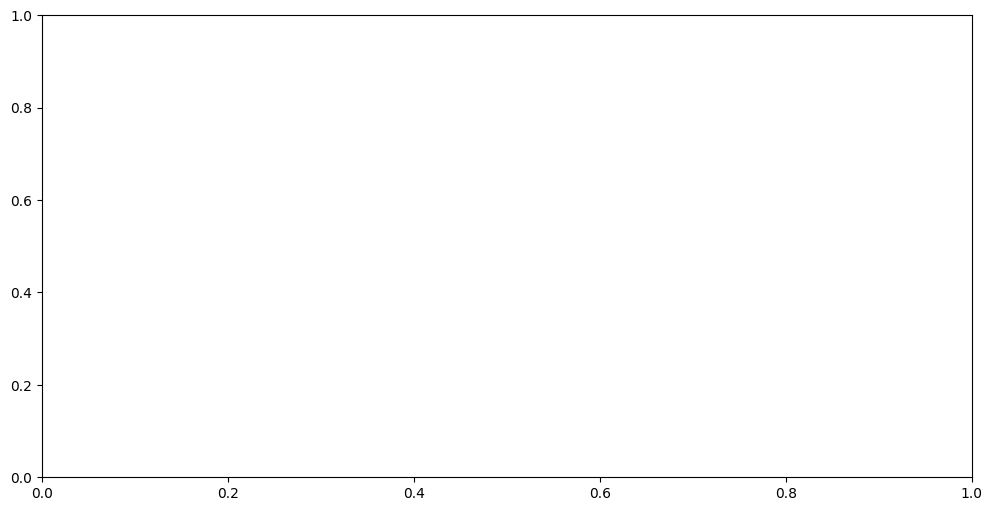

In [360]:
# Получение "сырых" предсказаний для анализа
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# Визуализация первых 10 примеров
for idx in range(10):  # Можно изменить число примеров
    fig, ax = plt.subplots(figsize=(12, 6))
    best_tft.plot_prediction(
        raw_predictions.x, 
        raw_predictions.output, 
        idx=idx, 
        add_loss_to_title=True, 
        ax=ax
    )
    plt.show()
